# Colour - HDRI - Examples: Merge from Raw Files with Post Demosaicing

Through this example, some Canon EOS 5D Mark II *CR2* files will be merged together prior to demosaicing in order to create a single radiance image.

> Note: The final result exhibits a magenta cast, we haven't investigated the exact origin yet.

The following steps will be taken:

- Conversion of the *CR2* files to *DNG* files using [Adobe DNG Converter](http://www.adobe.com/support/downloads/detail.jsp?ftpID=5957).
- Conversion of the *DNG* files to intermediate non demosaiced linear *Tiff* files using Dave Coffin's [dcraw](https://www.cybercom.net/~dcoffin/dcraw/).
- Creation of an image stack using *DNG* and intermediate *Tiff* files:
    - Reading of the *DNG* files *Exif* metadata using Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
    - Reading of the intermediate *Tiff* files pixel data using [OpenImageIO](http://openimageio.org/).
- Merging of the image stack into a radiance image.
- White balancing of the radiance image.
- Demosaicing of the radiance image.
- Conversion of the radiance image to *RGB* display colourspace.
- Display of the final resulting radiance image.

> Note: Some steps can be performed using alternative methods or simplified, for instance the *DNG* conversion can be entirely avoided. Our interest here is to retrieve the camera levels and the [Adobe DNG](https://helpx.adobe.com/photoshop/digital-negative.html) camera colour profiling data.

## CR2 Files Conversion to DNG and Intermediate Files

In [1]:
import logging
import numpy as np
import os
import platform

import colour
from colour_demosaicing import demosaicing_CFA_Bayer_DDFAPD, masks_CFA_Bayer

from colour_hdri import (
    EXAMPLES_RESOURCES_DIRECTORY,
    RAW_CONVERTER_ARGUMENTS_BAYER_CFA,
    Image,
    ImageStack,
    camera_space_to_sRGB,
    convert_dng_files_to_intermediate_files,
    convert_raw_files_to_dng_files,
    filter_files,
    read_exif_tag,
    image_stack_to_radiance_image,
    update_exif_tags,
    weighting_function_Debevec1997,
)
from colour_hdri.plotting import plot_radiance_image_strip

logging.basicConfig(level=logging.INFO)

RESOURCES_DIRECTORY = os.path.join(
    EXAMPLES_RESOURCES_DIRECTORY, "frobisher_001"
)

colour.plotting.colour_style()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.9.10 (main, Jan 15 2022, 11:40:53)                         *
*                [Clang 13.0.0 (clang-1300.0.29.3)]                           *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.4.1                                                        *
*       colour-demosaicing : 0.2.1                                            *
*       colour-hdri : v0.1.8-117-g65cb031                                     *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.16.0                                                      *
*       matplotlib : 3.4.3              

In [2]:
RAW_FILES = filter_files(RESOURCES_DIRECTORY, ("CR2",))

# In order to get proper black and white levels from .dng files
# we need to change the dng conversion arguments.
if platform.system() == "Darwin":
    DNG_CONVERTER_ARGUMENTS = '-e -d "{output_directory}" "{raw_file}"'
elif platform.system() in ("Windows", "Microsoft"):
    DNG_CONVERTER_ARGUMENTS = "-e -d {output_directory} {raw_file}"

DNG_FILES = convert_raw_files_to_dng_files(
    RAW_FILES,
    RESOURCES_DIRECTORY,
    dng_converter_arguments=DNG_CONVERTER_ARGUMENTS,
)

INTERMEDIATE_FILES = convert_dng_files_to_intermediate_files(
    DNG_FILES,
    RESOURCES_DIRECTORY,
    raw_converter_arguments=RAW_CONVERTER_ARGUMENTS_BAYER_CFA,
)

update_exif_tags(zip(DNG_FILES, INTERMEDIATE_FILES))

XYZ_TO_CAMERA_SPACE_MATRIX = colour.utilities.as_float_array(
    [
        float(M_c)
        for M_c in read_exif_tag(DNG_FILES[-2], "ColorMatrix2").split()
    ]
).reshape((3, 3))

INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.dng" file.
*** GPU Warning: GPU3 disabled via cr_config at init time. ***
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.dng" file.
*** GPU Warning: GPU3 disabled via cr_config at init time. ***
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2600.CR2" file to "/Users/kelsolaar/Documents/Development/

/Users/kelsolaar/Library/Caches/pypoetry/virtualenvs/colour-hdri-bkoxrqd3-py3.9/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


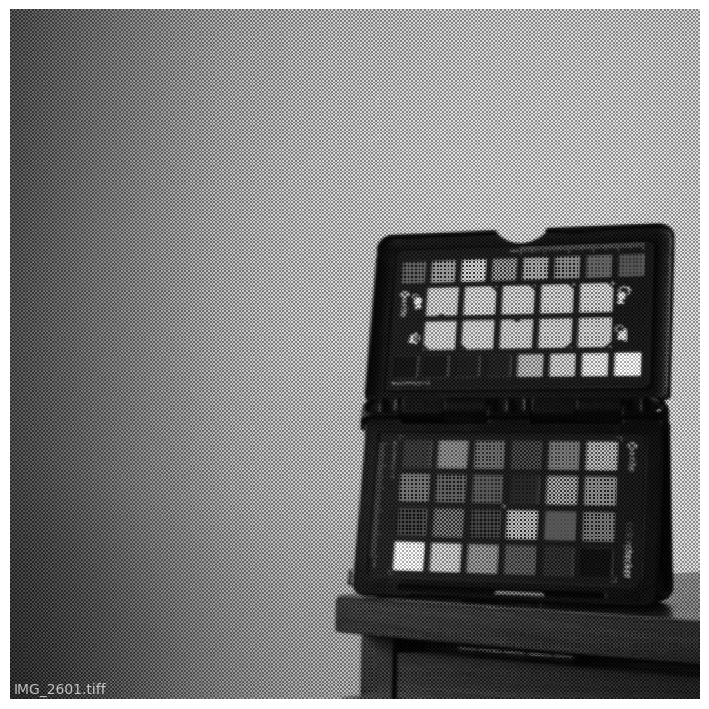

In [3]:
colour.plotting.plot_image(
    colour.cctf_encoding(
        colour.read_image(str(INTERMEDIATE_FILES[-2]))[
            1250:2250, 3000:4000, ...
        ]
    ),
    text_kwargs={"text": os.path.basename(INTERMEDIATE_FILES[-2])},
);

## Radiance Image Merge and Demosaicing

In [4]:
def merge_from_raw_files_with_post_demosaicing(
    dng_files,
    output_directory,
    batch_size=5,
    black_level=None,
    white_level=None,
    white_balance_multipliers=None,
    weighting_function=weighting_function_Debevec1997,
    CFA_pattern="RGGB",
):
    paths = []
    for dng_files in colour.utilities.batch(dng_files, batch_size):
        image_stack = ImageStack()
        for dng_file in dng_files:
            image = Image(dng_file)
            image.read_metadata()
            image.path = str(dng_file.replace("dng", "tiff"))
            image.read_data()
            image_stack.append(image)

        path = os.path.join(
            output_directory,
            "{0}_{1}_MRFPD.{2}".format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                "exr",
            ),
        )
        paths.append(path)

        logging.info('Scaling "{0}"...'.format(", ".join(image_stack.path)))
        black_level_e = (
            0
            if image_stack.black_level[0] is None
            else np.max(image_stack.black_level[0])
        )
        white_level_e = (
            1
            if image_stack.white_level[0] is None
            else np.min(image_stack.white_level[0])
        )
        logging.info(
            "\tBlack Level (Exif): {0}".format(image_stack.black_level)
        )
        logging.info(
            "\tWhite Level (Exif): {0}".format(image_stack.white_level)
        )
        black_level = black_level if black_level is not None else black_level_e
        white_level = white_level if white_level is not None else white_level_e
        logging.info("\tBlack Level (Used): {0}".format(black_level))
        logging.info("\tWhite Level (Used): {0}".format(white_level))
        # Scaling should be performed on individual planes, for convenience
        # and simplicity the maximum of the black level and the minimum of
        # the white level are used for all planes.
        image_stack.data = np.clip(
            (image_stack.data - black_level)
            * (1 / (white_level_e - black_level_e)),
            0,
            1,
        )

        for i, image in enumerate(image_stack):
            logging.info('White Balancing "{0}"...'.format(path))
            white_balance_multipliers_e = np.power(
                image_stack.white_balance_multipliers[i], -1
            )
            logging.info(
                "\tWhite Balance Multipliers (Exif): {0}".format(
                    white_balance_multipliers_e
                )
            )
            white_balance_multipliers = (
                white_balance_multipliers
                if white_balance_multipliers is not None
                else white_balance_multipliers_e
            )
            logging.info(
                "\tWhite Balance Multipliers (Used): {0}".format(
                    white_balance_multipliers
                )
            )
            R_m, G_m, B_m = masks_CFA_Bayer(image.data.shape, CFA_pattern)
            image.data[R_m] *= white_balance_multipliers[0]
            image.data[G_m] *= white_balance_multipliers[1]
            image.data[B_m] *= white_balance_multipliers[2]

            image.data = np.clip(image.data, 0, 1)

        logging.info('Merging "{0}"...'.format(path))
        logging.info(
            '\tImage stack "F Number" (Exif): {0}'.format(image_stack.f_number)
        )
        logging.info(
            '\tImage stack "Exposure Time" (Exif): {0}'.format(
                image_stack.exposure_time
            )
        )
        logging.info('\tImage stack "ISO" (Exif): {0}'.format(image_stack.iso))

        image = image_stack_to_radiance_image(image_stack, weighting_function)
        image[np.isnan(image)] = 0

        logging.info('Demosaicing "{0}"...'.format(path))
        image = demosaicing_CFA_Bayer_DDFAPD(image, CFA_pattern)

        logging.info('Writing "{0}"...'.format(path))
        colour.write_image(image, path)

    return paths


PATHS = merge_from_raw_files_with_post_demosaicing(
    DNG_FILES, RESOURCES_DIRECTORY
)

INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.dng" image metadata.
INFO:root:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.dng' image EXIF data.
INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.tiff" image.
/Users/kelsolaar/Library/Caches/pypoetry/virtualenvs/colour-hdri-bkoxrqd3-py3.9/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)
INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.dng" image metadata.
INFO:root:Reading '/

/Users/kelsolaar/Library/Caches/pypoetry/virtualenvs/colour-hdri-bkoxrqd3-py3.9/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourWarning: "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2600.tiff" image channels contain negative or equal to zero values, unpredictable results may occur! Please consider encoding your images in a wider gamut RGB colourspace or clamp negative values.
  warn(*args, **kwargs)
/Users/kelsolaar/Library/Caches/pypoetry/virtualenvs/colour-hdri-bkoxrqd3-py3.9/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourWarning: "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2601.tiff" image channels contain negative or equal to zero values, unpredictable results may occur! Please consider encoding your images in a wider gamut RGB colourspace or clamp negative valu

## Camera Space to sRGB Colourspace Conversion and Radiance Image Display

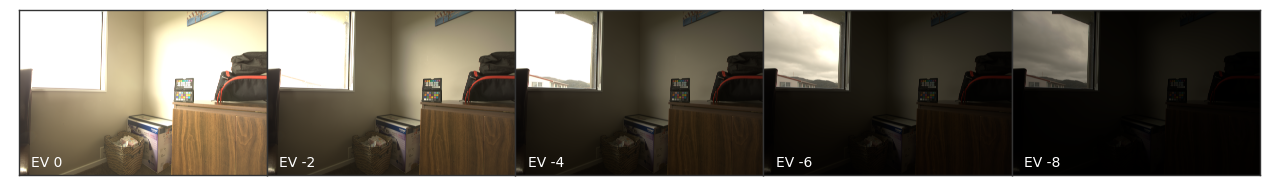

In [5]:
IMAGE = colour.read_image(PATHS[0])

IMAGE_sRGB = camera_space_to_sRGB(IMAGE, XYZ_TO_CAMERA_SPACE_MATRIX)

colour.write_image(IMAGE_sRGB, PATHS[0].replace(".exr", "_sRGB.exr"))

plot_radiance_image_strip(IMAGE_sRGB);